# Dark Energy Spectroscopic Instrument

Some calculations to assist with building the DESI model from an existing ZEMAX model and other sources.

You can safely ignore this if you just want to use the model.

In [1]:
import batoid
from batoid.utils import normalized
import os
import yaml
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Load the DESI model:

In [2]:
DESI_fn = os.path.join(batoid.datadir, 'DESI', 'DESI.yaml')
config = yaml.safe_load(open(DESI_fn))
fiducial_telescope = batoid.parse.parse_optic(config['opticalSystem'])

## Corrector Internal Baffles

Setup YAML to preserve dictionary order and trunctate distances (in meters) to 5 digits:

In [3]:
import collections

In [4]:
def dict_representer(dumper, data):
    return dumper.represent_dict(data.items())

yaml.Dumper.add_representer(collections.OrderedDict, dict_representer)

def float_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:float', f'{value:.5f}')

yaml.Dumper.add_representer(float, float_representer)

Define the corrector internal baffle apertures, from DESI-4103-v1.  These have been checked against DESI-4037-v6, with the extra baffle between ADC1 and ADC2 added:

In [5]:
# baffle z-coordinates relative to FP in mm from DESI-4103-v1, checked
# against DESI-4037-v6 (and with extra ADC baffle added).
ZBAFFLE = np.array([
    2302.91, 2230.29, 1916.86, 1823.57, 1617.37, 1586.76, 1457.88, 1349.45, 1314.68,
    1232.06, 899.67, 862.08, 568.81, 483.84, 415.22])    
# baffle radii in mm from DESI-4103-v1, checked
# against DESI-4037-v6 (and with extra ADC baffle added).
RBAFFLE = np.array([
    558.80, 544.00, 447.75, 417.00, 376.00, 376.00, 378.00, 378.00, 395.00,
    403.00, 448.80, 453.70, 492.00, 501.00, 496.00])

Calculate batoid Baffle surfaces for the corrector.  These are mechanically planar, but that would put their (planar) center inside a lens, breaking the sequential tracing model.  We fix this by use spherical baffle surfaces that have the same apertures. This code was originally used to read a batoid model without baffles, but also works if the baffles are already added.

In [6]:
def baffles(nindent=10):
    indent = ' ' * nindent
    # Measure z from C1 front face in m.
    zbaffle = 1e-3 * (2425.007 - ZBAFFLE)
    # Convert r from mm to m.
    rbaffle = 1e-3 * RBAFFLE
    # By default, all baffles are planar.
    nbaffles = len(zbaffle)
    baffles = []
    for i in range(nbaffles):
        baffle = collections.OrderedDict()
        baffle['type'] = 'Baffle'
        baffle['name'] = f'B{i+1}'
        baffle['coordSys'] = {'z': float(zbaffle[i])}
        baffle['surface'] = {'type': 'Plane'}
        baffle['obscuration'] = {'type': 'ClearCircle', 'radius': float(rbaffle[i])}
        baffles.append(baffle)
    # Loop over corrector lenses.
    corrector = fiducial_telescope.itemDict['DESI.Hexapod.Corrector']
    lenses = 'C1', 'C2', 'ADC1rotator.ADC1', 'ADC2rotator.ADC2', 'C3', 'C4'
    for lens in lenses:
        obj = corrector.itemDict['Corrector.' + lens]
        assert isinstance(obj, batoid.optic.Lens)
        front, back = obj.items[0], obj.items[1]
        fTransform = batoid.CoordTransform(front.coordSys, corrector.coordSys)
        bTransform = batoid.CoordTransform(back.coordSys, corrector.coordSys)
        _, _, zfront = fTransform.applyForward(0, 0, 0)
        _, _, zback = bTransform.applyForward(0, 0, 0)
        # Find any baffles "inside" this lens.
        inside = (zbaffle >= zfront) & (zbaffle <= zback)
        if not any(inside):
            continue
        inside = np.where(inside)[0]
        for k in inside:
            baffle = baffles[k]
            r = rbaffle[k]
            # Calculate sag at (x,y)=(0,r) to avoid effect of ADC rotation about y.
            sagf, sagb = front.surface.sag(0, r), back.surface.sag(0, r)
            _, _, zf = fTransform.applyForward(0, r, sagf)
            _, _, zb = bTransform.applyForward(0, r, sagb)
            if zf > zbaffle[k]:
                print(f'{indent}# Move B{k+1} in front of {obj.name} and make spherical to keep model sequential.')
                assert isinstance(front.surface, batoid.Sphere)
                baffle['surface'] = {'type': 'Sphere', 'R': front.surface.R}
                baffle['coordSys']['z'] = float(zfront - (zf - zbaffle[k]))
            elif zbaffle[k] > zb:
                print(f'{indent}# Move B{k+1} behind {obj.name} and make spherical to keep model sequential.')
                assert isinstance(back.surface, batoid.Sphere)
                baffle['surface'] = {'type': 'Sphere', 'R': back.surface.R}
                baffle['coordSys']['z'] = float(zback + (zbaffle[k] - zb))
            else:
                print(f'Cannot find a solution for B{k+1} inside {obj.name}!')

    lines = yaml.dump(baffles)
    for line in lines.split('\n'):
        print(indent + line)

baffles()

          # Move B1 in front of C1 and make spherical to keep model sequential.
          # Move B7 in front of ADC2 and make spherical to keep model sequential.
          # Move B10 behind C3 and make spherical to keep model sequential.
          # Move B13 in front of C4 and make spherical to keep model sequential.
          # Move B14 in front of C4 and make spherical to keep model sequential.
          # Move B15 behind C4 and make spherical to keep model sequential.
          - type: Baffle
            name: B1
            coordSys:
              z: -0.01793
            surface:
              R: 1.18499
              type: Sphere
            obscuration:
              radius: 0.55880
              type: ClearCircle
          - type: Baffle
            name: B2
            coordSys:
              z: 0.19472
            surface:
              type: Plane
            obscuration:
              radius: 0.54400
              type: ClearCircle
          - type: Baffle
            name: 

Validate that the baffle edges in the final model have the correct apertures:

In [7]:
def validate_baffles():
    corrector = fiducial_telescope.itemDict['DESI.Hexapod.Corrector']
    for i in range(len(ZBAFFLE)):
        baffle = corrector.itemDict[f'Corrector.B{i+1}']
        # Calculate surface z at origin in corrector coordinate system.
        _, _, z = batoid.CoordTransform(baffle.coordSys, corrector.coordSys).applyForward(0, 0, 0)
        # Calculate surface z at (r,0) in corrector coordinate system.
        sag = baffle.surface.sag(1e-3 * RBAFFLE[i], 0)
        z += sag
        # Measure from FP in mm.
        z = np.round(2425.007 - 1e3 * z, 2)
        assert z == ZBAFFLE[i], baffle.name
        
validate_baffles()

## Corrector Cage and Spider

Calculate simplified vane coordinates using parameters from DESI-4110-v1:

          -
            type: ClearAnnulus
            inner: 0.881
            outer: 2.47015
          -
            type: ObscRectangle
            x: 1.05198
            y: -0.87333
            width: 0.0285
            height: 2.23184
            theta: -2.46964
          -
            type: ObscRectangle
            x: 1.05198
            y: 0.87333
            width: 0.0285
            height: 2.23184
            theta: -0.67195
          -
            type: ObscRectangle
            x: -1.05198
            y: 0.87333
            width: 0.06
            height: 2.23184
            theta: 0.67195
          -
            type: ObscRectangle
            x: -1.05198
            y: -0.87333
            width: 0.0191
            height: 2.23184
            theta: 2.46964
-
  type: ObscRectangle
  x: -0.09209
  y: 0.87617
  width: 0.3
  height: 0.154
  theta: 0.10472


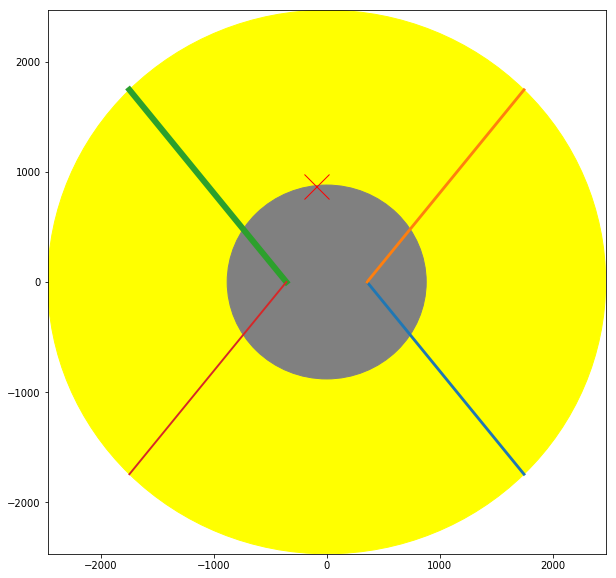

In [8]:
def spider(dmin=1762, dmax=4940.3, ns_angle=77, widths=[28.5, 28.5, 60., 19.1],
           wart_r=958, wart_dth=6, wart_w=300):
    # Vane order is [NE, SE, SW, NW], with N along -y and E along +x.
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_artist(plt.Circle((0, 0), 0.5 * dmax, color='yellow'))
    ax.add_artist(plt.Circle((0, 0), 0.5 * dmin, color='gray'))
    ax.set_xlim(-0.5 * dmax, 0.5 * dmax)
    ax.set_ylim(-0.5 * dmax, 0.5 * dmax)
    
    # Place outer vertices equally along the outer ring at NE, SE, SW, NW.
    xymax = 0.5 * dmax * np.array([[1, -1], [1, 1], [-1, 1], [-1, -1]]) / np.sqrt(2)
    # Calculate inner vertices so that the planes of the NE and NW vanes intersect
    # with an angle of ns_angle (same for the SE and SW planes).
    angle = np.deg2rad(ns_angle)
    x = xymax[1, 0]
    dx = xymax[1, 1] * np.tan(0.5 * angle)
    xymin = np.array([[x - dx, 0], [x - dx, 0], [-x+dx, 0], [-x+dx, 0]])
    for i in range(4):
        plt.plot([xymin[i,0], xymax[i,0]], [xymin[i,1], xymax[i,1]], '-', lw=0.1 * widths[i])

    # Calculate batoid rectangle params for the vanes.
    xy0 = 0.5 * (xymin + xymax)
    heights = np.sqrt(np.sum((xymax - xymin) ** 2, axis=1))

    # Calculate wart rectangle coords.
    wart_h = 2 * (wart_r - 0.5 * dmin)
    wart_dth = np.deg2rad(wart_dth)
    wart_xy = 0.5 * dmin * np.array([-np.sin(wart_dth), np.cos(wart_dth)])
    plt.plot(*wart_xy, 'rx', ms=25)
    # Print batoid config.
    indent = ' ' * 10
    print(f'{indent}-\n{indent}  type: ClearAnnulus')
    print(f'{indent}  inner: {np.round(0.5e-3 * dmin, 5)}')
    print(f'{indent}  outer: {np.round(0.5e-3 * dmax, 5)}')
    for i in range(4):
        print(f'{indent}-\n{indent}  type: ObscRectangle')
        print(f'{indent}  x: {np.round(1e-3 * xy0[i, 0], 5)}')
        print(f'{indent}  y: {np.round(1e-3 * xy0[i, 1], 5)}')
        print(f'{indent}  width: {np.round(1e-3 * widths[i], 5)}')
        print(f'{indent}  height: {np.round(1e-3 * heights[i], 5)}')
        dx, dy = xymax[i] - xymin[i]
        angle = np.arctan2(-dx, dy)
        print(f'{indent}  theta: {np.round(angle, 5)}')
    print(f'-\n  type: ObscRectangle')
    print(f'  x: {np.round(1e-3 * wart_xy[0], 5)}')
    print(f'  y: {np.round(1e-3 * wart_xy[1], 5)}')
    print(f'  width: {np.round(1e-3 * wart_w, 5)}')
    print(f'  height: {np.round(1e-3 * wart_h, 5)}')
    print(f'  theta: {np.round(wart_dth, 5)}')
    
spider()

Plot "User Aperture Data" from the ZEMAX "spider" surface 6, as cross check:

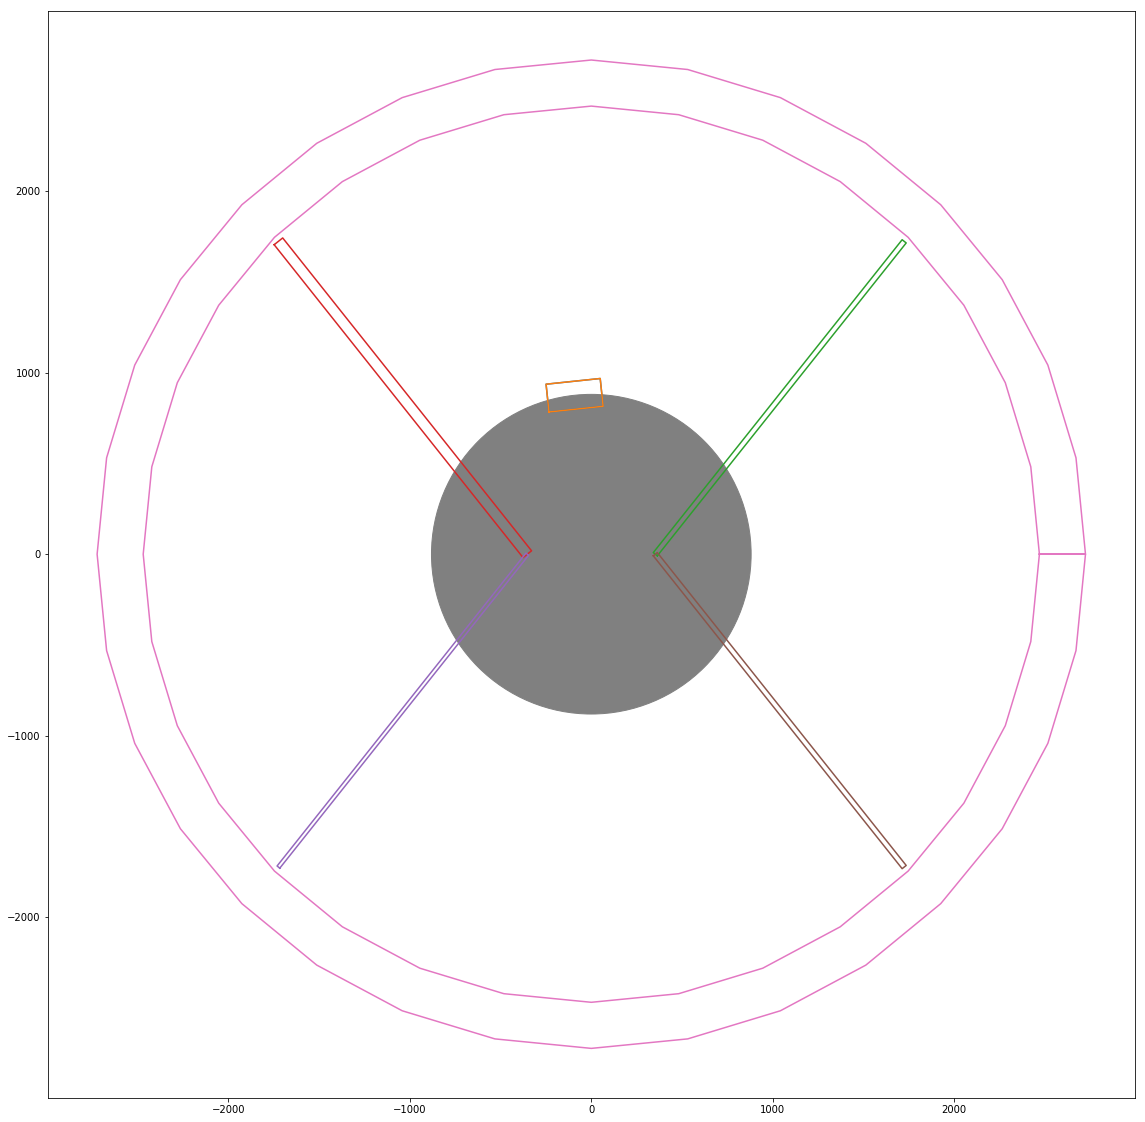

In [9]:
def plot_obs():
    wart1 = np.array([
        [ -233.22959, 783.94254],
        [-249.32698, 937.09892],
        [49.02959, 968.45746],
        [ 65.126976, 815.30108],
        [ -233.22959, 783.94254],
    ])
    wart2 = np.array([
        [-233.22959, 783.94254],
        [ -249.32698, 937.09892],
        [49.029593, 968.45746],
        [65.126976, 815.30108],
        [-233.22959, 783.94254],
    ])
    vane1 = np.array([
        [363.96554,-8.8485008],
        [341.66121, 8.8931664],
        [1713.4345, 1733.4485],
        [1735.7388, 1715.7068],
        [363.96554,-8.8485008],
    ])
    vane2 = np.array([
        [-1748.0649, 1705.9022],
        [ -1701.1084, 1743.2531],
        [ -329.33513, 18.697772],
        [ -376.29162, -18.653106],
        [-1748.0649, 1705.9022],
    ])
    vane3 = np.array([
        [ -1717.1127, -1730.5227],
        [ -1732.0605, -1718.6327],
        [ -360.28728, 5.922682],
        [-345.33947, -5.9673476],
        [ -1717.1127, -1730.5227],
    ])
    vane4 = np.array([
        [ 341.66121, -8.8931664],
        [363.96554, 8.8485008],
        [1735.7388, -1715.7068],
        [1713.4345, -1733.4485],
        [ 341.66121, -8.8931664],
    ])
    extra = np.array([
        [           2470 ,               0 ],
        [      2422.5396 ,       -481.8731 ],
        [      2281.9824 ,      -945.22808 ],
        [      2053.7299 ,      -1372.2585 ],
        [      1746.5537 ,      -1746.5537 ],
        [      1372.2585 ,      -2053.7299 ],
        [      945.22808 ,      -2281.9824 ],
        [       481.8731 ,      -2422.5396 ],
        [  3.0248776e-13 ,           -2470 ],
        [      -481.8731 ,      -2422.5396 ],
        [     -945.22808 ,      -2281.9824 ],
        [     -1372.2585 ,      -2053.7299 ],
        [     -1746.5537 ,      -1746.5537 ],
        [     -2053.7299 ,      -1372.2585 ],
        [     -2281.9824 ,      -945.22808 ],
        [     -2422.5396 ,       -481.8731 ],
        [          -2470 ,   2.9882133e-12 ],
        [     -2422.5396 ,        481.8731 ],
        [     -2281.9824 ,       945.22808 ],
        [     -2053.7299 ,       1372.2585 ],
        [     -1746.5537 ,       1746.5537 ],
        [     -1372.2585 ,       2053.7299 ],
        [     -945.22808 ,       2281.9824 ],
        [      -481.8731 ,       2422.5396 ],
        [  5.9764266e-12 ,            2470 ],
        [       481.8731 ,       2422.5396 ],
        [      945.22808 ,       2281.9824 ],
        [      1372.2585 ,       2053.7299 ],
        [      1746.5537 ,       1746.5537 ],
        [      2053.7299 ,       1372.2585 ],
        [      2281.9824 ,       945.22808 ],
        [      2422.5396 ,        481.8731 ],
        [           2470 ,  -1.0364028e-11 ],
        [           2724 ,               0 ],
        [      2671.6591 ,      -531.42604 ],
        [      2516.6478 ,      -1042.4297 ],
        [      2264.9232 ,      -1513.3733 ],
        [      1926.1589 ,      -1926.1589 ],
        [      1513.3733 ,      -2264.9232 ],
        [      1042.4297 ,      -2516.6478 ],
        [      531.42604 ,      -2671.6591 ],
        [  3.3359379e-13 ,           -2724 ],
        [     -531.42604 ,      -2671.6591 ],
        [     -1042.4297 ,      -2516.6478 ],
        [     -1513.3733 ,      -2264.9232 ],
        [     -1926.1589 ,      -1926.1589 ],
        [     -2264.9232 ,      -1513.3733 ],
        [     -2516.6478 ,      -1042.4297 ],
        [     -2671.6591 ,      -531.42604 ],
        [          -2724 ,   3.2955032e-12 ],
        [     -2671.6591 ,       531.42604 ],
        [     -2516.6478 ,       1042.4297 ],
        [     -2264.9232 ,       1513.3733 ],
        [     -1926.1589 ,       1926.1589 ],
        [     -1513.3733 ,       2264.9232 ],
        [     -1042.4297 ,       2516.6478 ],
        [     -531.42604 ,       2671.6591 ],
        [  6.5910065e-12 ,            2724 ],
        [      531.42604 ,       2671.6591 ],
        [      1042.4297 ,       2516.6478 ],
        [      1513.3733 ,       2264.9232 ],
        [      1926.1589 ,       1926.1589 ],
        [      2264.9232 ,       1513.3733 ],
        [      2516.6478 ,       1042.4297 ],
        [      2671.6591 ,       531.42604 ],
        [           2724 ,  -1.1429803e-11 ],
        [           2470 ,               0 ],
    ])
    plt.figure(figsize=(20, 20))
    plt.plot(*wart1.T)
    plt.plot(*wart2.T)
    plt.plot(*vane1.T)
    plt.plot(*vane2.T)
    plt.plot(*vane3.T)
    plt.plot(*vane4.T)
    plt.plot(*extra.T)
    w = 1762./2.
    plt.gca().add_artist(plt.Circle((0, 0), w, color='gray'))
    plt.gca().set_aspect(1.)
    
plot_obs()